# Exercise | Probalistic Methods (DISCRETE)

### Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'   
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
print(df.count())
df.head()

ip                13974
timestamp         13974
request_method    13974
request_path      13974
http_version      13974
status_code       13974
size              13974
user_agent        13974
dtype: int64


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


 ## Synthetic Records 

In [3]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = pd.concat([df,new])

In [4]:
print(df.count())

df.head()

ip                13978
timestamp         13978
request_method    13978
request_path      13978
http_version      13978
status_code       13978
size              13978
user_agent        13978
dtype: int64


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


# Detecting Anomalies in Discrete Variables

We can easily see some anomalies around IP addresses.

To detect anomalies in discrete variables we can look at two ways of summarizing the variable:

> count: the number of times each unique value appears in the dataset
> 
> frequencies: the number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations

In [5]:
df['size_mb'] = df['size'] / 1024 / 1024 # conversion from bytes to kylobytes to megabytes in the new column
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [6]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [7]:
df.ip.value_counts().head()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: ip, dtype: int64

In [8]:
df.ip.value_counts(normalize=True).head()

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
Name: ip, dtype: float64

## Defined Function used to combine both pieces of information:

In [9]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('freq'),
        left_index=True,
        right_index=True,
    )

In [10]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,freq
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


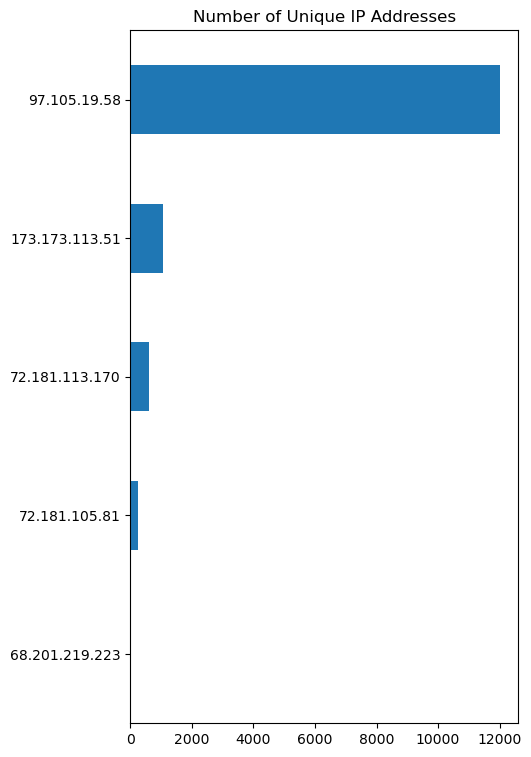

In [11]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.title('Number of Unique IP Addresses')
plt.show()

# Conditional Probabilities: Probabilities using 2 discrete variables

## prob(A|B) = prob(A&B)/prob(B)


### If we are looking for an unexpected status (like authentication failure) from a known/common IP address.

In [12]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('freq_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,freq_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [13]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,freq_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [14]:
df[df.ip == '97.105.15.120']


,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [15]:
status_given_ip[status_given_ip.freq_status_given_ip < 1]


,ip,status_code,freq_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


# Using the original ADA dataframe (with no new entries)

## Let's Investiagte further

In [16]:
#make sure the original has 4 less entries
len(df), len(new)

(13978, 4)

In [17]:
#look at ip address, their status and the probability it will be that status
og_status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
og_status_given_ip.sample(10)

,ip,status_code,proba_status_given_ip
6,35.174.209.2,200,1.000000
14,68.201.219.223,200,1.000000
17,72.181.113.170,200,0.996737
21,97.105.15.120,301,1.000000
19,95.31.16.121,301,1.000000
11,52.91.30.150,200,1.000000
13,54.172.14.223,200,1.000000
0,173.173.113.51,200,1.000000
9,52.87.230.102,200,1.000000
10,52.90.165.200,200,1.000000


In [18]:
# Essentially a list of the probability of each ip/status code combination
og_status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [19]:
#set date to index, merge on ip and status
df = df.reset_index().merge(status_given_ip, on=['ip', 'status_code'], how='left').fillna(value=0).set_index('timestamp')
df['size_mb'] = df['size'] / 1024 / 1024 # conversion from bytes to kylobytes to megabytes in the new column

In [20]:
df.shape

(13978, 9)

In [21]:
#only give me the ips that have less than 15% unsuccessful accesses
uns_df = df[df.freq_status_given_ip < 0.15]

In [22]:
uns_df.shape

(16, 9)

In [23]:
uns_df.index.value_counts()

2019-04-16 19:55:15    1
2019-04-16 19:56:02    1
2019-04-16 20:28:46    1
2019-04-16 20:33:24    1
2019-04-16 20:38:13    1
2019-04-16 20:38:55    1
2019-04-16 20:39:00    1
2019-04-16 20:45:17    1
2019-04-16 20:45:28    1
2019-04-16 21:00:35    1
2019-04-16 21:02:07    1
2019-04-16 21:30:46    1
2019-04-16 21:39:21    1
2019-04-16 22:21:38    1
2019-04-17 02:48:36    1
2019-04-17 03:42:44    1
Name: timestamp, dtype: int64

In [24]:
uns_df.ip.value_counts()

97.105.19.58      14
72.181.113.170     2
Name: ip, dtype: int64

In [25]:
uns_df.value_counts()

ip              request_method  request_path            http_version  status_code  size  user_agent              size_mb  freq_status_given_ip
97.105.19.58    GET             /api/v1/items           HTTP/1.1      499          0     python-requests/2.21.0  0.0      0.001167                4
                                /api/v1/sales?page=2    HTTP/1.1      499          0     python-requests/2.21.0  0.0      0.001167                2
72.181.113.170  GET             /api/v1/sales?page=133  HTTP/1.1      499          0     python-requests/2.21.0  0.0      0.003263                1
                                /api/v1/sales?page=8    HTTP/1.1      499          0     python-requests/2.21.0  0.0      0.003263                1
97.105.19.58    GET             /api/v1/sales?page=115  HTTP/1.1      499          0     python-requests/2.20.1  0.0      0.001167                1
                                /api/v1/sales?page=2    HTTP/1.1      499          0     python-requests/2.20.1  0.0 

  ## There are Threee IP addresses that have experienced an Error Status code at least once or multiple times whe trying to gain access to the curriculum

## Going to investigate size on og dataframe and then check again on the uns < 15% dataframe after

In [26]:
sizemb_df = value_counts_and_frequencies(df.size_mb)
sizemb_df.head(10)

,count,freq
0.471896,705,0.050436
0.003396,548,0.039204
0.003489,291,0.020818
0.001266,229,0.016383
0.001704,219,0.015667
0.471025,209,0.014952
0.486502,183,0.013092
0.486509,179,0.012806
0.486506,129,0.009229
0.486511,126,0.009014


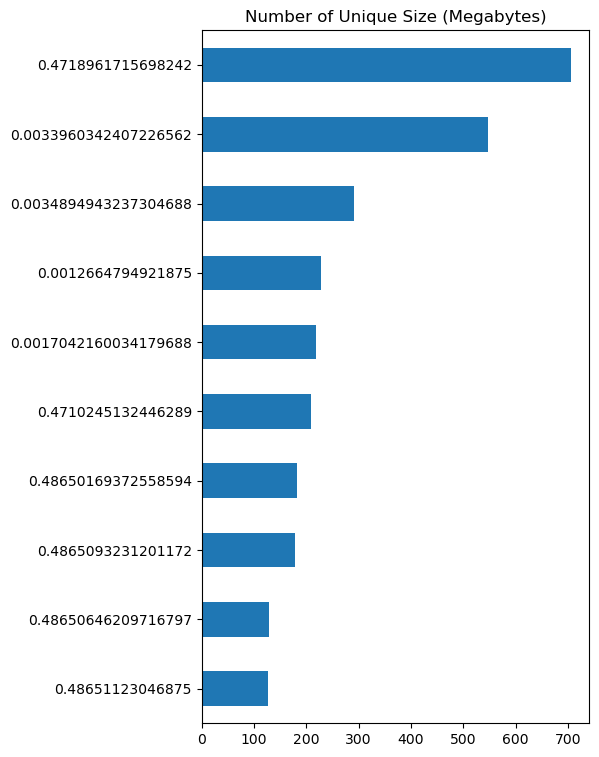

In [27]:
sizemb_df['count'].sort_values().tail(10).plot.barh(figsize=(5, 9))
plt.title('Number of Unique Size (Megabytes)')
plt.show()

### There is a approximately a 47% frequency of megabyte size in our data set.

## Timestamp Traffic

In [28]:
timestamp_df = value_counts_and_frequencies(df.index)
timestamp_df

,count,freq
2019-04-16 19:56:10,9,0.000644
2019-04-16 19:49:58,8,0.000572
2019-04-16 20:01:30,7,0.000501
2019-04-16 20:12:23,6,0.000429
2019-04-16 20:02:59,6,0.000429
...,...,...
2019-04-16 21:10:11,1,0.000072
2019-04-16 21:10:09,1,0.000072
2019-04-16 21:10:07,1,0.000072
2019-04-16 21:10:05,1,0.000072


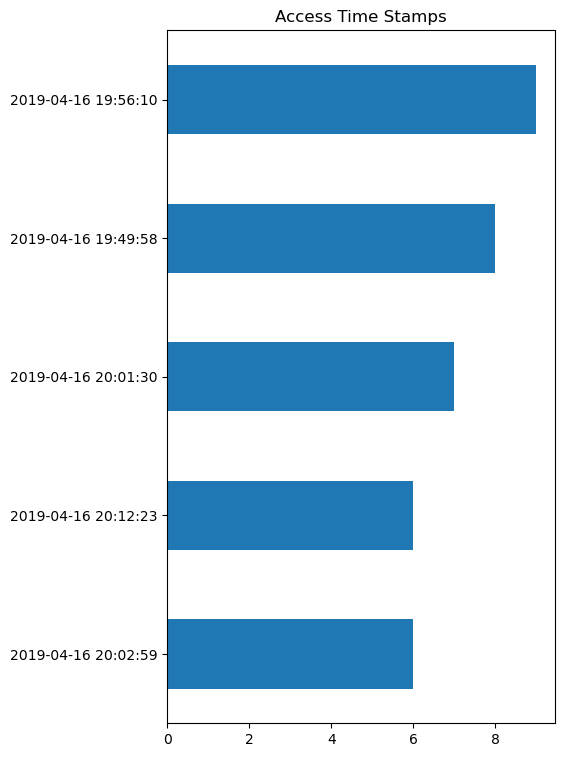

In [29]:
timestamp_df['count'].sort_values().tail().plot.barh(figsize=(5, 9))
plt.title('Access Time Stamps')
plt.show()

## highest Timestamp recorded at 2019-04-16 19:56:10 and traffic was high at between 7:56PM to 8:10PM

  ## Now I will begin using two discrete variables

In [30]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,freq_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,0.998833
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,0.998833
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472,0.998833
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377,0.998833
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246,0.998833


## size_mb | ip probability

In [31]:
size_given_ip = (
    df.groupby('ip')
    .size_mb.value_counts(normalize=True)
    .rename('freq_size_given_ip')
    .reset_index()
)
size_given_ip.head()

,ip,size_mb,freq_size_given_ip
0,173.173.113.51,0.003396,0.060434
1,173.173.113.51,0.001704,0.058546
2,173.173.113.51,0.003489,0.058546
3,173.173.113.51,0.001266,0.050992
4,173.173.113.51,0.486502,0.013220


In [44]:
size_given_ip[size_given_ip.freq_size_given_ip <= 0.000100]

,ip,size_mb,freq_size_given_ip
743,97.105.19.58,0.000120,0.000083
744,97.105.19.58,0.265481,0.000083
745,97.105.19.58,0.312356,0.000083
746,97.105.19.58,0.327981,0.000083
747,97.105.19.58,0.343606,0.000083
748,97.105.19.58,1.961066,0.000083


## The same IP address had a size_mb of 2mb or less from their request

In [50]:
size_given_ip[size_given_ip.freq_size_given_ip < 0.75]

,ip,size_mb,freq_size_given_ip
0,173.173.113.51,0.003396,0.060434
1,173.173.113.51,0.001704,0.058546
2,173.173.113.51,0.003489,0.058546
3,173.173.113.51,0.001266,0.050992
4,173.173.113.51,0.486502,0.013220
...,...,...,...
744,97.105.19.58,0.265481,0.000083
745,97.105.19.58,0.312356,0.000083
746,97.105.19.58,0.327981,0.000083
747,97.105.19.58,0.343606,0.000083


In [51]:
size_given_ip[size_given_ip.freq_size_given_ip > 0.75]

,ip,size_mb,freq_size_given_ip
181,3.88.129.158,0.003396,1.0
182,3.92.201.136,0.000040,1.0
183,34.207.64.242,0.000154,1.0
184,34.229.70.250,0.000154,1.0
185,35.174.209.2,0.000154,1.0
188,45.23.250.16,0.001266,1.0
191,52.90.165.200,0.000154,1.0
192,52.91.30.150,0.000040,1.0
193,54.145.52.184,0.000154,1.0
194,54.172.14.223,0.000154,1.0


## Nothing to note here